MrBeam is composed of various software packages: 
-> ehtim (for the general handling of VLBI data)
-> regpy (tool for inverse problems)
-> WISE (tool for a wavelet based analysis of images)
-> MSI (multiscale operator handling)
-> imagingbase (containing the new VLBI imaging capabilities)

In this tutorial we will present some of the key features of regpy: we show how we can invert the Volterra operator with regpy.

In [1]:
#Load basic modules and setup logger
import numpy as np
import logging
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

First we define the forward operator (i.e. the Volterra operator). We have to define a proper domain and codomain first, in this case we just use a uniform grid.

In [2]:
from regpy.discrs import UniformGrid
from regpy.operators.volterra import Volterra

grid = UniformGrid(np.linspace(0, 2*np.pi, 200))
op = Volterra(grid, exponent=3)

Now we can create synthetic data and add noise. The discretization implementation has some helper functions (coords, randn, ones, ...) for this purpose.

In [3]:
exact_solution = np.sin(op.domain.coords[0])
exact_data = op(exact_solution)
noise = 0.03 * op.domain.randn()
data = exact_data + noise
init = op.domain.ones()

We are equipping the operator "op: domain --> codomain" with a Hilbert space structure. The inner product and the respective Gram matrices will be inserted in the inversion procedure automatically. Here we are using a L2 codomain and a smooth domain (Sobolev with index 2).

In [4]:
from regpy.solvers import HilbertSpaceSetting
from regpy.hilbert import L2, Sobolev
setting = HilbertSpaceSetting(op=op, Hdomain=Sobolev(index=2), Hcodomain=L2)

Now we are defining the regularization technique: an irgnm_cg inversion.

In [5]:
from regpy.solvers.irgnm import IrgnmCG
solver = IrgnmCG(setting, data, regpar=1, regpar_step=0.9, init=init.copy())

We specify a stopping rule: stopping by maximal number of iterations or by the discrepancy principle.

In [6]:
import regpy.stoprules as rules
stoprule = (
    rules.CountIterations(max_iterations=100) +
    rules.Discrepancy(
        setting.Hcodomain.norm, data,
        noiselevel=setting.Hcodomain.norm(noise),
        tau=1.1
    )
)

Run the inversion procedure with this stopping rule and display the result.

2023-10-18 14:04:09,227 INFO IrgnmCG              :: Running Tikhonov solver.
2023-10-18 14:04:09,251 INFO TikhonovCG           :: Solver converged.
2023-10-18 14:04:09,252 INFO CountIterations      :: iteration = 1 / 100
2023-10-18 14:04:09,253 INFO Discrepancy          :: relative discrepancy = 32.43926434265692, tolerance = 1.1
2023-10-18 14:04:09,253 INFO IrgnmCG              :: Running Tikhonov solver.
2023-10-18 14:04:09,262 INFO TikhonovCG           :: Solver converged.
2023-10-18 14:04:09,263 INFO CountIterations      :: iteration = 2 / 100
2023-10-18 14:04:09,264 INFO Discrepancy          :: relative discrepancy = 16.8691180691137, tolerance = 1.1
2023-10-18 14:04:09,265 INFO IrgnmCG              :: Running Tikhonov solver.
2023-10-18 14:04:09,273 INFO TikhonovCG           :: Solver converged.
2023-10-18 14:04:09,274 INFO CountIterations      :: iteration = 3 / 100
2023-10-18 14:04:09,275 INFO Discrepancy          :: relative discrepancy = 20.95193026305886, tolerance = 1.1
20

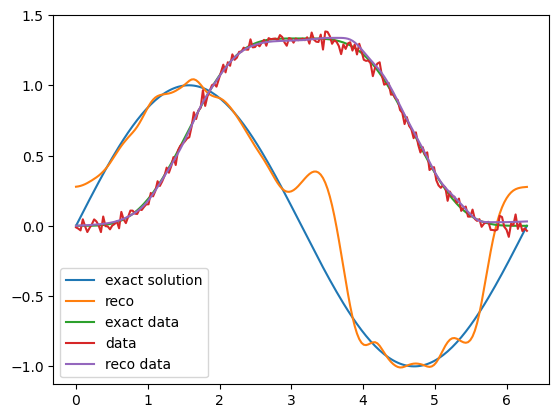

In [7]:
reco, reco_data = solver.run(stoprule)

plt.plot(grid.coords[0], exact_solution.T, label='exact solution')
plt.plot(grid.coords[0], reco, label='reco')
plt.plot(grid.coords[0], exact_data, label='exact data')
plt.plot(grid.coords[0], data, label='data')
plt.plot(grid.coords[0], reco_data, label='reco data')
plt.legend()
plt.show()

IRGNM_CG is gradient based solver. However, not all data fidelity terms and penalty terms possess a uniquely defined gradient (e.g. total variation, L1, ...). Therefore, we provide a framework for convex optimization of general objective functionals in imagingbase. Here we present TV regularization:

In [8]:
from regpy.functionals import TV, HilbertNorm

data_fidelity_operator = op - data
data_fidelity = HilbertNorm(setting.Hcodomain) * data_fidelity_operator
"""The penalty term: 1/2 * ||f||_{TV}^2"""
penalty = TV(setting.Hdomain.discr, Hdomain=setting.Hdomain)

This also demonstrates another property of regpy: operators can be added, multiplied with constant factors and combined with functionals or other operators. The respective gradients and derivatives by the chain rule are handled by regpy internally. This makes it most easy to work with operator combinations or operators/functionals on product spaces.

We do the minimization by the proximal-point based FISTA algorithm. The proximal point algorithm of the TV penalty term is computed by the Chambolle-Pock algorithm.

In [9]:
from regpy.solvers.fista import FISTA

"""Parameters for the inner computation of the proximal operator with the Chambolle algorithm"""
proximal_pars = {
        'stepsize' : 0.001,
        'maxiter' : 100
        }

tau = 0.01
alpha = 0.01

solver = FISTA(setting, data_fidelity, penalty, init.copy(), tau = tau, regpar = alpha, proximal_pars=proximal_pars)

As above we define a stopping rule, run the minimization and display the result:

2023-10-18 14:04:50,075 INFO CountIterations      :: iteration = 1 / 100000
2023-10-18 14:04:50,075 INFO Discrepancy          :: relative discrepancy = 26.00408301977569, tolerance = 1.3
2023-10-18 14:04:50,095 INFO CountIterations      :: iteration = 2 / 100000
2023-10-18 14:04:50,095 INFO Discrepancy          :: relative discrepancy = 24.537343506939227, tolerance = 1.3
2023-10-18 14:04:50,114 INFO CountIterations      :: iteration = 3 / 100000
2023-10-18 14:04:50,115 INFO Discrepancy          :: relative discrepancy = 23.227698288779788, tolerance = 1.3
2023-10-18 14:04:50,136 INFO CountIterations      :: iteration = 4 / 100000
2023-10-18 14:04:50,136 INFO Discrepancy          :: relative discrepancy = 22.115882296687946, tolerance = 1.3
2023-10-18 14:04:50,155 INFO CountIterations      :: iteration = 5 / 100000
2023-10-18 14:04:50,156 INFO Discrepancy          :: relative discrepancy = 21.180682089782866, tolerance = 1.3
2023-10-18 14:04:50,176 INFO CountIterations      :: iteratio

2022-07-27 16:19:15,493 INFO Discrepancy          :: relative discrepancy = 14.21206842196744, tolerance = 1.3
2022-07-27 16:19:15,521 INFO CountIterations      :: iteration = 176 / 100000
2022-07-27 16:19:15,523 INFO Discrepancy          :: relative discrepancy = 14.211629631463754, tolerance = 1.3
2022-07-27 16:19:15,552 INFO CountIterations      :: iteration = 177 / 100000
2022-07-27 16:19:15,553 INFO Discrepancy          :: relative discrepancy = 14.211204290088615, tolerance = 1.3
2022-07-27 16:19:15,583 INFO CountIterations      :: iteration = 178 / 100000
2022-07-27 16:19:15,584 INFO Discrepancy          :: relative discrepancy = 14.210764580797907, tolerance = 1.3
2022-07-27 16:19:15,614 INFO CountIterations      :: iteration = 179 / 100000
2022-07-27 16:19:15,614 INFO Discrepancy          :: relative discrepancy = 14.210342028814987, tolerance = 1.3
2022-07-27 16:19:15,643 INFO CountIterations      :: iteration = 180 / 100000
2022-07-27 16:19:15,643 INFO Discrepancy          :

2022-07-27 16:19:16,903 INFO CountIterations      :: iteration = 219 / 100000
2022-07-27 16:19:16,904 INFO Discrepancy          :: relative discrepancy = 14.196604196933949, tolerance = 1.3
2022-07-27 16:19:16,938 INFO CountIterations      :: iteration = 220 / 100000
2022-07-27 16:19:16,940 INFO Discrepancy          :: relative discrepancy = 14.196364116111303, tolerance = 1.3
2022-07-27 16:19:16,972 INFO CountIterations      :: iteration = 221 / 100000
2022-07-27 16:19:16,973 INFO Discrepancy          :: relative discrepancy = 14.196119538749775, tolerance = 1.3
2022-07-27 16:19:17,006 INFO CountIterations      :: iteration = 222 / 100000
2022-07-27 16:19:17,007 INFO Discrepancy          :: relative discrepancy = 14.195884733901291, tolerance = 1.3
2022-07-27 16:19:17,037 INFO CountIterations      :: iteration = 223 / 100000
2022-07-27 16:19:17,038 INFO Discrepancy          :: relative discrepancy = 14.195660964872557, tolerance = 1.3
2022-07-27 16:19:17,068 INFO CountIterations      

2022-07-27 16:19:18,281 INFO Discrepancy          :: relative discrepancy = 14.188130878320832, tolerance = 1.3
2022-07-27 16:19:18,309 INFO CountIterations      :: iteration = 263 / 100000
2022-07-27 16:19:18,310 INFO Discrepancy          :: relative discrepancy = 14.187988130432446, tolerance = 1.3
2022-07-27 16:19:18,338 INFO CountIterations      :: iteration = 264 / 100000
2022-07-27 16:19:18,339 INFO Discrepancy          :: relative discrepancy = 14.187835264685408, tolerance = 1.3
2022-07-27 16:19:18,367 INFO CountIterations      :: iteration = 265 / 100000
2022-07-27 16:19:18,368 INFO Discrepancy          :: relative discrepancy = 14.187685439908728, tolerance = 1.3
2022-07-27 16:19:18,398 INFO CountIterations      :: iteration = 266 / 100000
2022-07-27 16:19:18,399 INFO Discrepancy          :: relative discrepancy = 14.18755067818314, tolerance = 1.3
2022-07-27 16:19:18,426 INFO CountIterations      :: iteration = 267 / 100000
2022-07-27 16:19:18,428 INFO Discrepancy          :

2022-07-27 16:19:19,625 INFO CountIterations      :: iteration = 306 / 100000
2022-07-27 16:19:19,626 INFO Discrepancy          :: relative discrepancy = 14.182413596411179, tolerance = 1.3
2022-07-27 16:19:19,652 INFO CountIterations      :: iteration = 307 / 100000
2022-07-27 16:19:19,653 INFO Discrepancy          :: relative discrepancy = 14.182313151946227, tolerance = 1.3
2022-07-27 16:19:19,689 INFO CountIterations      :: iteration = 308 / 100000
2022-07-27 16:19:19,690 INFO Discrepancy          :: relative discrepancy = 14.182225597180336, tolerance = 1.3
2022-07-27 16:19:19,721 INFO CountIterations      :: iteration = 309 / 100000
2022-07-27 16:19:19,722 INFO Discrepancy          :: relative discrepancy = 14.182159215975421, tolerance = 1.3
2022-07-27 16:19:19,752 INFO CountIterations      :: iteration = 310 / 100000
2022-07-27 16:19:19,754 INFO Discrepancy          :: relative discrepancy = 14.182103336937649, tolerance = 1.3
2022-07-27 16:19:19,784 INFO CountIterations      

2022-07-27 16:19:20,909 INFO Discrepancy          :: relative discrepancy = 14.179050561168129, tolerance = 1.3
2022-07-27 16:19:20,936 INFO CountIterations      :: iteration = 350 / 100000
2022-07-27 16:19:20,937 INFO Discrepancy          :: relative discrepancy = 14.178964992169039, tolerance = 1.3
2022-07-27 16:19:20,965 INFO CountIterations      :: iteration = 351 / 100000
2022-07-27 16:19:20,966 INFO Discrepancy          :: relative discrepancy = 14.178880725035137, tolerance = 1.3
2022-07-27 16:19:20,993 INFO CountIterations      :: iteration = 352 / 100000
2022-07-27 16:19:20,993 INFO Discrepancy          :: relative discrepancy = 14.178791219407339, tolerance = 1.3
2022-07-27 16:19:21,020 INFO CountIterations      :: iteration = 353 / 100000
2022-07-27 16:19:21,021 INFO Discrepancy          :: relative discrepancy = 14.17870073630317, tolerance = 1.3
2022-07-27 16:19:21,051 INFO CountIterations      :: iteration = 354 / 100000
2022-07-27 16:19:21,052 INFO Discrepancy          :

2022-07-27 16:19:22,241 INFO CountIterations      :: iteration = 393 / 100000
2022-07-27 16:19:22,242 INFO Discrepancy          :: relative discrepancy = 14.176379385483779, tolerance = 1.3
2022-07-27 16:19:22,272 INFO CountIterations      :: iteration = 394 / 100000
2022-07-27 16:19:22,273 INFO Discrepancy          :: relative discrepancy = 14.176338986478092, tolerance = 1.3
2022-07-27 16:19:22,300 INFO CountIterations      :: iteration = 395 / 100000
2022-07-27 16:19:22,301 INFO Discrepancy          :: relative discrepancy = 14.176303822111343, tolerance = 1.3
2022-07-27 16:19:22,331 INFO CountIterations      :: iteration = 396 / 100000
2022-07-27 16:19:22,332 INFO Discrepancy          :: relative discrepancy = 14.17625986738266, tolerance = 1.3
2022-07-27 16:19:22,361 INFO CountIterations      :: iteration = 397 / 100000
2022-07-27 16:19:22,362 INFO Discrepancy          :: relative discrepancy = 14.176195259587166, tolerance = 1.3
2022-07-27 16:19:22,393 INFO CountIterations      :

2022-07-27 16:19:23,583 INFO Discrepancy          :: relative discrepancy = 14.174448686095968, tolerance = 1.3
2022-07-27 16:19:23,613 INFO CountIterations      :: iteration = 437 / 100000
2022-07-27 16:19:23,614 INFO Discrepancy          :: relative discrepancy = 14.174416810866717, tolerance = 1.3
2022-07-27 16:19:23,642 INFO CountIterations      :: iteration = 438 / 100000
2022-07-27 16:19:23,643 INFO Discrepancy          :: relative discrepancy = 14.174386953602903, tolerance = 1.3
2022-07-27 16:19:23,672 INFO CountIterations      :: iteration = 439 / 100000
2022-07-27 16:19:23,673 INFO Discrepancy          :: relative discrepancy = 14.174365496398856, tolerance = 1.3
2022-07-27 16:19:23,701 INFO CountIterations      :: iteration = 440 / 100000
2022-07-27 16:19:23,702 INFO Discrepancy          :: relative discrepancy = 14.174350756927781, tolerance = 1.3
2022-07-27 16:19:23,731 INFO CountIterations      :: iteration = 441 / 100000
2022-07-27 16:19:23,732 INFO Discrepancy          

2022-07-27 16:19:24,892 INFO CountIterations      :: iteration = 480 / 100000
2022-07-27 16:19:24,893 INFO Discrepancy          :: relative discrepancy = 14.173292168550256, tolerance = 1.3
2022-07-27 16:19:24,932 INFO CountIterations      :: iteration = 481 / 100000
2022-07-27 16:19:24,933 INFO Discrepancy          :: relative discrepancy = 14.173247416668138, tolerance = 1.3
2022-07-27 16:19:24,965 INFO CountIterations      :: iteration = 482 / 100000
2022-07-27 16:19:24,966 INFO Discrepancy          :: relative discrepancy = 14.173199348970739, tolerance = 1.3
2022-07-27 16:19:24,996 INFO CountIterations      :: iteration = 483 / 100000
2022-07-27 16:19:24,997 INFO Discrepancy          :: relative discrepancy = 14.173144401986375, tolerance = 1.3
2022-07-27 16:19:25,026 INFO CountIterations      :: iteration = 484 / 100000
2022-07-27 16:19:25,027 INFO Discrepancy          :: relative discrepancy = 14.173087604618855, tolerance = 1.3
2022-07-27 16:19:25,057 INFO CountIterations      

2022-07-27 16:19:26,196 INFO Discrepancy          :: relative discrepancy = 14.17253463979803, tolerance = 1.3
2022-07-27 16:19:26,224 INFO CountIterations      :: iteration = 524 / 100000
2022-07-27 16:19:26,225 INFO Discrepancy          :: relative discrepancy = 14.172512976064246, tolerance = 1.3
2022-07-27 16:19:26,253 INFO CountIterations      :: iteration = 525 / 100000
2022-07-27 16:19:26,254 INFO Discrepancy          :: relative discrepancy = 14.172479544407892, tolerance = 1.3
2022-07-27 16:19:26,287 INFO CountIterations      :: iteration = 526 / 100000
2022-07-27 16:19:26,288 INFO Discrepancy          :: relative discrepancy = 14.17243147874137, tolerance = 1.3
2022-07-27 16:19:26,316 INFO CountIterations      :: iteration = 527 / 100000
2022-07-27 16:19:26,317 INFO Discrepancy          :: relative discrepancy = 14.172390046421999, tolerance = 1.3
2022-07-27 16:19:26,345 INFO CountIterations      :: iteration = 528 / 100000
2022-07-27 16:19:26,346 INFO Discrepancy          ::

2022-07-27 16:19:27,513 INFO CountIterations      :: iteration = 567 / 100000
2022-07-27 16:19:27,515 INFO Discrepancy          :: relative discrepancy = 14.171094333121427, tolerance = 1.3
2022-07-27 16:19:27,546 INFO CountIterations      :: iteration = 568 / 100000
2022-07-27 16:19:27,547 INFO Discrepancy          :: relative discrepancy = 14.171080586845292, tolerance = 1.3
2022-07-27 16:19:27,577 INFO CountIterations      :: iteration = 569 / 100000
2022-07-27 16:19:27,578 INFO Discrepancy          :: relative discrepancy = 14.171057138325118, tolerance = 1.3
2022-07-27 16:19:27,606 INFO CountIterations      :: iteration = 570 / 100000
2022-07-27 16:19:27,607 INFO Discrepancy          :: relative discrepancy = 14.171046338926887, tolerance = 1.3
2022-07-27 16:19:27,635 INFO CountIterations      :: iteration = 571 / 100000
2022-07-27 16:19:27,636 INFO Discrepancy          :: relative discrepancy = 14.1710402773093, tolerance = 1.3
2022-07-27 16:19:27,663 INFO CountIterations      ::

2022-07-27 16:19:28,817 INFO Discrepancy          :: relative discrepancy = 14.17059812861878, tolerance = 1.3
2022-07-27 16:19:28,847 INFO CountIterations      :: iteration = 611 / 100000
2022-07-27 16:19:28,848 INFO Discrepancy          :: relative discrepancy = 14.170526536156034, tolerance = 1.3
2022-07-27 16:19:28,878 INFO CountIterations      :: iteration = 612 / 100000
2022-07-27 16:19:28,879 INFO Discrepancy          :: relative discrepancy = 14.17044102557107, tolerance = 1.3
2022-07-27 16:19:28,905 INFO CountIterations      :: iteration = 613 / 100000
2022-07-27 16:19:28,906 INFO Discrepancy          :: relative discrepancy = 14.170356845617615, tolerance = 1.3
2022-07-27 16:19:28,934 INFO CountIterations      :: iteration = 614 / 100000
2022-07-27 16:19:28,935 INFO Discrepancy          :: relative discrepancy = 14.170291774376263, tolerance = 1.3
2022-07-27 16:19:28,962 INFO CountIterations      :: iteration = 615 / 100000
2022-07-27 16:19:28,963 INFO Discrepancy          ::

2022-07-27 16:19:30,158 INFO CountIterations      :: iteration = 654 / 100000
2022-07-27 16:19:30,159 INFO Discrepancy          :: relative discrepancy = 14.170325337019229, tolerance = 1.3
2022-07-27 16:19:30,189 INFO CountIterations      :: iteration = 655 / 100000
2022-07-27 16:19:30,190 INFO Discrepancy          :: relative discrepancy = 14.170295056317519, tolerance = 1.3
2022-07-27 16:19:30,218 INFO CountIterations      :: iteration = 656 / 100000
2022-07-27 16:19:30,219 INFO Discrepancy          :: relative discrepancy = 14.170271076450081, tolerance = 1.3
2022-07-27 16:19:30,250 INFO CountIterations      :: iteration = 657 / 100000
2022-07-27 16:19:30,250 INFO Discrepancy          :: relative discrepancy = 14.170256066664477, tolerance = 1.3
2022-07-27 16:19:30,278 INFO CountIterations      :: iteration = 658 / 100000
2022-07-27 16:19:30,279 INFO Discrepancy          :: relative discrepancy = 14.170241802200811, tolerance = 1.3
2022-07-27 16:19:30,307 INFO CountIterations      

2022-07-27 16:19:31,503 INFO Discrepancy          :: relative discrepancy = 14.16980496535692, tolerance = 1.3
2022-07-27 16:19:31,528 INFO CountIterations      :: iteration = 698 / 100000
2022-07-27 16:19:31,529 INFO Discrepancy          :: relative discrepancy = 14.169821010669908, tolerance = 1.3
2022-07-27 16:19:31,557 INFO CountIterations      :: iteration = 699 / 100000
2022-07-27 16:19:31,558 INFO Discrepancy          :: relative discrepancy = 14.169837714389994, tolerance = 1.3
2022-07-27 16:19:31,587 INFO CountIterations      :: iteration = 700 / 100000
2022-07-27 16:19:31,588 INFO Discrepancy          :: relative discrepancy = 14.169848491985121, tolerance = 1.3
2022-07-27 16:19:31,616 INFO CountIterations      :: iteration = 701 / 100000
2022-07-27 16:19:31,618 INFO Discrepancy          :: relative discrepancy = 14.16983045227987, tolerance = 1.3
2022-07-27 16:19:31,647 INFO CountIterations      :: iteration = 702 / 100000
2022-07-27 16:19:31,648 INFO Discrepancy          ::

2022-07-27 16:19:32,905 INFO CountIterations      :: iteration = 741 / 100000
2022-07-27 16:19:32,906 INFO Discrepancy          :: relative discrepancy = 14.16943312228452, tolerance = 1.3
2022-07-27 16:19:32,940 INFO CountIterations      :: iteration = 742 / 100000
2022-07-27 16:19:32,941 INFO Discrepancy          :: relative discrepancy = 14.169425081403928, tolerance = 1.3
2022-07-27 16:19:32,978 INFO CountIterations      :: iteration = 743 / 100000
2022-07-27 16:19:32,980 INFO Discrepancy          :: relative discrepancy = 14.169406158706163, tolerance = 1.3
2022-07-27 16:19:33,016 INFO CountIterations      :: iteration = 744 / 100000
2022-07-27 16:19:33,018 INFO Discrepancy          :: relative discrepancy = 14.169388080766556, tolerance = 1.3
2022-07-27 16:19:33,049 INFO CountIterations      :: iteration = 745 / 100000
2022-07-27 16:19:33,051 INFO Discrepancy          :: relative discrepancy = 14.169374676510563, tolerance = 1.3
2022-07-27 16:19:33,081 INFO CountIterations      :

2022-07-27 16:19:34,296 INFO Discrepancy          :: relative discrepancy = 14.169412528609644, tolerance = 1.3
2022-07-27 16:19:34,326 INFO CountIterations      :: iteration = 785 / 100000
2022-07-27 16:19:34,327 INFO Discrepancy          :: relative discrepancy = 14.169403667427096, tolerance = 1.3
2022-07-27 16:19:34,356 INFO CountIterations      :: iteration = 786 / 100000
2022-07-27 16:19:34,357 INFO Discrepancy          :: relative discrepancy = 14.16940807253499, tolerance = 1.3
2022-07-27 16:19:34,387 INFO CountIterations      :: iteration = 787 / 100000
2022-07-27 16:19:34,387 INFO Discrepancy          :: relative discrepancy = 14.169396184747718, tolerance = 1.3
2022-07-27 16:19:34,418 INFO CountIterations      :: iteration = 788 / 100000
2022-07-27 16:19:34,419 INFO Discrepancy          :: relative discrepancy = 14.169396792487406, tolerance = 1.3
2022-07-27 16:19:34,450 INFO CountIterations      :: iteration = 789 / 100000
2022-07-27 16:19:34,451 INFO Discrepancy          :

2022-07-27 16:19:35,633 INFO CountIterations      :: iteration = 828 / 100000
2022-07-27 16:19:35,634 INFO Discrepancy          :: relative discrepancy = 14.169346648152482, tolerance = 1.3
2022-07-27 16:19:35,664 INFO CountIterations      :: iteration = 829 / 100000
2022-07-27 16:19:35,664 INFO Discrepancy          :: relative discrepancy = 14.169335627863747, tolerance = 1.3
2022-07-27 16:19:35,692 INFO CountIterations      :: iteration = 830 / 100000
2022-07-27 16:19:35,692 INFO Discrepancy          :: relative discrepancy = 14.169342583778967, tolerance = 1.3
2022-07-27 16:19:35,722 INFO CountIterations      :: iteration = 831 / 100000
2022-07-27 16:19:35,723 INFO Discrepancy          :: relative discrepancy = 14.169348866739993, tolerance = 1.3
2022-07-27 16:19:35,751 INFO CountIterations      :: iteration = 832 / 100000
2022-07-27 16:19:35,752 INFO Discrepancy          :: relative discrepancy = 14.169322286949214, tolerance = 1.3
2022-07-27 16:19:35,781 INFO CountIterations      

2022-07-27 16:19:36,925 INFO Discrepancy          :: relative discrepancy = 14.168902193947496, tolerance = 1.3
2022-07-27 16:19:36,957 INFO CountIterations      :: iteration = 872 / 100000
2022-07-27 16:19:36,958 INFO Discrepancy          :: relative discrepancy = 14.16885334430502, tolerance = 1.3
2022-07-27 16:19:36,991 INFO CountIterations      :: iteration = 873 / 100000
2022-07-27 16:19:36,993 INFO Discrepancy          :: relative discrepancy = 14.16879960552268, tolerance = 1.3
2022-07-27 16:19:37,035 INFO CountIterations      :: iteration = 874 / 100000
2022-07-27 16:19:37,036 INFO Discrepancy          :: relative discrepancy = 14.168774764112047, tolerance = 1.3
2022-07-27 16:19:37,069 INFO CountIterations      :: iteration = 875 / 100000
2022-07-27 16:19:37,070 INFO Discrepancy          :: relative discrepancy = 14.168739961880748, tolerance = 1.3
2022-07-27 16:19:37,105 INFO CountIterations      :: iteration = 876 / 100000
2022-07-27 16:19:37,106 INFO Discrepancy          ::

2022-07-27 16:19:38,361 INFO CountIterations      :: iteration = 915 / 100000
2022-07-27 16:19:38,362 INFO Discrepancy          :: relative discrepancy = 14.168657352637188, tolerance = 1.3
2022-07-27 16:19:38,397 INFO CountIterations      :: iteration = 916 / 100000
2022-07-27 16:19:38,398 INFO Discrepancy          :: relative discrepancy = 14.168667767063981, tolerance = 1.3
2022-07-27 16:19:38,428 INFO CountIterations      :: iteration = 917 / 100000
2022-07-27 16:19:38,429 INFO Discrepancy          :: relative discrepancy = 14.168664966845176, tolerance = 1.3
2022-07-27 16:19:38,464 INFO CountIterations      :: iteration = 918 / 100000
2022-07-27 16:19:38,465 INFO Discrepancy          :: relative discrepancy = 14.168660290006997, tolerance = 1.3
2022-07-27 16:19:38,495 INFO CountIterations      :: iteration = 919 / 100000
2022-07-27 16:19:38,496 INFO Discrepancy          :: relative discrepancy = 14.168650441842814, tolerance = 1.3
2022-07-27 16:19:38,525 INFO CountIterations      

2022-07-27 16:19:39,682 INFO Discrepancy          :: relative discrepancy = 14.169085902679928, tolerance = 1.3
2022-07-27 16:19:39,717 INFO CountIterations      :: iteration = 959 / 100000
2022-07-27 16:19:39,718 INFO Discrepancy          :: relative discrepancy = 14.169109371001163, tolerance = 1.3
2022-07-27 16:19:39,749 INFO CountIterations      :: iteration = 960 / 100000
2022-07-27 16:19:39,751 INFO Discrepancy          :: relative discrepancy = 14.169114897053515, tolerance = 1.3
2022-07-27 16:19:39,780 INFO CountIterations      :: iteration = 961 / 100000
2022-07-27 16:19:39,782 INFO Discrepancy          :: relative discrepancy = 14.169101808845296, tolerance = 1.3
2022-07-27 16:19:39,812 INFO CountIterations      :: iteration = 962 / 100000
2022-07-27 16:19:39,813 INFO Discrepancy          :: relative discrepancy = 14.169095590006895, tolerance = 1.3
2022-07-27 16:19:39,842 INFO CountIterations      :: iteration = 963 / 100000
2022-07-27 16:19:39,844 INFO Discrepancy          

2022-07-27 16:19:41,130 INFO CountIterations      :: iteration = 1002 / 100000
2022-07-27 16:19:41,131 INFO Discrepancy          :: relative discrepancy = 14.168570247384787, tolerance = 1.3
2022-07-27 16:19:41,162 INFO CountIterations      :: iteration = 1003 / 100000
2022-07-27 16:19:41,163 INFO Discrepancy          :: relative discrepancy = 14.168616667032154, tolerance = 1.3
2022-07-27 16:19:41,191 INFO CountIterations      :: iteration = 1004 / 100000
2022-07-27 16:19:41,192 INFO Discrepancy          :: relative discrepancy = 14.168660914169832, tolerance = 1.3
2022-07-27 16:19:41,224 INFO CountIterations      :: iteration = 1005 / 100000
2022-07-27 16:19:41,225 INFO Discrepancy          :: relative discrepancy = 14.168721247457661, tolerance = 1.3
2022-07-27 16:19:41,252 INFO CountIterations      :: iteration = 1006 / 100000
2022-07-27 16:19:41,253 INFO Discrepancy          :: relative discrepancy = 14.168769236152821, tolerance = 1.3
2022-07-27 16:19:41,282 INFO CountIterations 

2022-07-27 16:19:42,509 INFO CountIterations      :: iteration = 1045 / 100000
2022-07-27 16:19:42,510 INFO Discrepancy          :: relative discrepancy = 14.168546730552839, tolerance = 1.3
2022-07-27 16:19:42,543 INFO CountIterations      :: iteration = 1046 / 100000
2022-07-27 16:19:42,544 INFO Discrepancy          :: relative discrepancy = 14.168581694720123, tolerance = 1.3
2022-07-27 16:19:42,575 INFO CountIterations      :: iteration = 1047 / 100000
2022-07-27 16:19:42,576 INFO Discrepancy          :: relative discrepancy = 14.168604691259494, tolerance = 1.3
2022-07-27 16:19:42,608 INFO CountIterations      :: iteration = 1048 / 100000
2022-07-27 16:19:42,609 INFO Discrepancy          :: relative discrepancy = 14.168631792773363, tolerance = 1.3
2022-07-27 16:19:42,637 INFO CountIterations      :: iteration = 1049 / 100000
2022-07-27 16:19:42,639 INFO Discrepancy          :: relative discrepancy = 14.168651882414055, tolerance = 1.3
2022-07-27 16:19:42,670 INFO CountIterations 

2022-07-27 16:19:43,848 INFO CountIterations      :: iteration = 1088 / 100000
2022-07-27 16:19:43,848 INFO Discrepancy          :: relative discrepancy = 14.168892332084182, tolerance = 1.3
2022-07-27 16:19:43,878 INFO CountIterations      :: iteration = 1089 / 100000
2022-07-27 16:19:43,880 INFO Discrepancy          :: relative discrepancy = 14.168898594977772, tolerance = 1.3
2022-07-27 16:19:43,909 INFO CountIterations      :: iteration = 1090 / 100000
2022-07-27 16:19:43,910 INFO Discrepancy          :: relative discrepancy = 14.168882852155932, tolerance = 1.3
2022-07-27 16:19:43,938 INFO CountIterations      :: iteration = 1091 / 100000
2022-07-27 16:19:43,939 INFO Discrepancy          :: relative discrepancy = 14.168868875518736, tolerance = 1.3
2022-07-27 16:19:43,965 INFO CountIterations      :: iteration = 1092 / 100000
2022-07-27 16:19:43,966 INFO Discrepancy          :: relative discrepancy = 14.168833998174655, tolerance = 1.3
2022-07-27 16:19:43,995 INFO CountIterations 

2022-07-27 16:19:45,198 INFO CountIterations      :: iteration = 1131 / 100000
2022-07-27 16:19:45,200 INFO Discrepancy          :: relative discrepancy = 14.168610442551396, tolerance = 1.3
2022-07-27 16:19:45,232 INFO CountIterations      :: iteration = 1132 / 100000
2022-07-27 16:19:45,233 INFO Discrepancy          :: relative discrepancy = 14.168566030366735, tolerance = 1.3
2022-07-27 16:19:45,262 INFO CountIterations      :: iteration = 1133 / 100000
2022-07-27 16:19:45,263 INFO Discrepancy          :: relative discrepancy = 14.16850961817657, tolerance = 1.3
2022-07-27 16:19:45,292 INFO CountIterations      :: iteration = 1134 / 100000
2022-07-27 16:19:45,293 INFO Discrepancy          :: relative discrepancy = 14.168462123539705, tolerance = 1.3
2022-07-27 16:19:45,321 INFO CountIterations      :: iteration = 1135 / 100000
2022-07-27 16:19:45,322 INFO Discrepancy          :: relative discrepancy = 14.168413742867466, tolerance = 1.3
2022-07-27 16:19:45,348 INFO CountIterations  

2022-07-27 16:19:46,569 INFO CountIterations      :: iteration = 1174 / 100000
2022-07-27 16:19:46,569 INFO Discrepancy          :: relative discrepancy = 14.168662114699028, tolerance = 1.3
2022-07-27 16:19:46,597 INFO CountIterations      :: iteration = 1175 / 100000
2022-07-27 16:19:46,597 INFO Discrepancy          :: relative discrepancy = 14.168646502584652, tolerance = 1.3
2022-07-27 16:19:46,626 INFO CountIterations      :: iteration = 1176 / 100000
2022-07-27 16:19:46,627 INFO Discrepancy          :: relative discrepancy = 14.16863893199864, tolerance = 1.3
2022-07-27 16:19:46,654 INFO CountIterations      :: iteration = 1177 / 100000
2022-07-27 16:19:46,655 INFO Discrepancy          :: relative discrepancy = 14.1686302686695, tolerance = 1.3
2022-07-27 16:19:46,687 INFO CountIterations      :: iteration = 1178 / 100000
2022-07-27 16:19:46,688 INFO Discrepancy          :: relative discrepancy = 14.168632069315665, tolerance = 1.3
2022-07-27 16:19:46,714 INFO CountIterations    

2022-07-27 16:19:47,812 INFO CountIterations      :: iteration = 1217 / 100000
2022-07-27 16:19:47,813 INFO Discrepancy          :: relative discrepancy = 14.168875593688771, tolerance = 1.3
2022-07-27 16:19:47,839 INFO CountIterations      :: iteration = 1218 / 100000
2022-07-27 16:19:47,840 INFO Discrepancy          :: relative discrepancy = 14.168823058407604, tolerance = 1.3
2022-07-27 16:19:47,868 INFO CountIterations      :: iteration = 1219 / 100000
2022-07-27 16:19:47,869 INFO Discrepancy          :: relative discrepancy = 14.168761231859367, tolerance = 1.3
2022-07-27 16:19:47,898 INFO CountIterations      :: iteration = 1220 / 100000
2022-07-27 16:19:47,899 INFO Discrepancy          :: relative discrepancy = 14.168696810447727, tolerance = 1.3
2022-07-27 16:19:47,924 INFO CountIterations      :: iteration = 1221 / 100000
2022-07-27 16:19:47,925 INFO Discrepancy          :: relative discrepancy = 14.168651051381739, tolerance = 1.3
2022-07-27 16:19:47,951 INFO CountIterations 

2022-07-27 16:19:49,032 INFO CountIterations      :: iteration = 1260 / 100000
2022-07-27 16:19:49,033 INFO Discrepancy          :: relative discrepancy = 14.168403423217127, tolerance = 1.3
2022-07-27 16:19:49,059 INFO CountIterations      :: iteration = 1261 / 100000
2022-07-27 16:19:49,060 INFO Discrepancy          :: relative discrepancy = 14.168388973953306, tolerance = 1.3
2022-07-27 16:19:49,086 INFO CountIterations      :: iteration = 1262 / 100000
2022-07-27 16:19:49,087 INFO Discrepancy          :: relative discrepancy = 14.168356896855999, tolerance = 1.3
2022-07-27 16:19:49,113 INFO CountIterations      :: iteration = 1263 / 100000
2022-07-27 16:19:49,114 INFO Discrepancy          :: relative discrepancy = 14.168334699554283, tolerance = 1.3
2022-07-27 16:19:49,139 INFO CountIterations      :: iteration = 1264 / 100000
2022-07-27 16:19:49,140 INFO Discrepancy          :: relative discrepancy = 14.168316012989713, tolerance = 1.3
2022-07-27 16:19:49,165 INFO CountIterations 

2022-07-27 16:19:50,227 INFO CountIterations      :: iteration = 1303 / 100000
2022-07-27 16:19:50,228 INFO Discrepancy          :: relative discrepancy = 14.168566378787643, tolerance = 1.3
2022-07-27 16:19:50,254 INFO CountIterations      :: iteration = 1304 / 100000
2022-07-27 16:19:50,255 INFO Discrepancy          :: relative discrepancy = 14.168529282944125, tolerance = 1.3
2022-07-27 16:19:50,280 INFO CountIterations      :: iteration = 1305 / 100000
2022-07-27 16:19:50,281 INFO Discrepancy          :: relative discrepancy = 14.168497978694013, tolerance = 1.3
2022-07-27 16:19:50,306 INFO CountIterations      :: iteration = 1306 / 100000
2022-07-27 16:19:50,307 INFO Discrepancy          :: relative discrepancy = 14.168486098958402, tolerance = 1.3
2022-07-27 16:19:50,333 INFO CountIterations      :: iteration = 1307 / 100000
2022-07-27 16:19:50,334 INFO Discrepancy          :: relative discrepancy = 14.168472291035735, tolerance = 1.3
2022-07-27 16:19:50,361 INFO CountIterations 

2022-07-27 16:19:51,465 INFO CountIterations      :: iteration = 1346 / 100000
2022-07-27 16:19:51,466 INFO Discrepancy          :: relative discrepancy = 14.168854997542828, tolerance = 1.3
2022-07-27 16:19:51,498 INFO CountIterations      :: iteration = 1347 / 100000
2022-07-27 16:19:51,499 INFO Discrepancy          :: relative discrepancy = 14.168838732568085, tolerance = 1.3
2022-07-27 16:19:51,527 INFO CountIterations      :: iteration = 1348 / 100000
2022-07-27 16:19:51,528 INFO Discrepancy          :: relative discrepancy = 14.168822794010852, tolerance = 1.3
2022-07-27 16:19:51,558 INFO CountIterations      :: iteration = 1349 / 100000
2022-07-27 16:19:51,559 INFO Discrepancy          :: relative discrepancy = 14.168786528435723, tolerance = 1.3
2022-07-27 16:19:51,590 INFO CountIterations      :: iteration = 1350 / 100000
2022-07-27 16:19:51,590 INFO Discrepancy          :: relative discrepancy = 14.168754464469563, tolerance = 1.3
2022-07-27 16:19:51,619 INFO CountIterations 

2022-07-27 16:19:53,151 INFO CountIterations      :: iteration = 1389 / 100000
2022-07-27 16:19:53,152 INFO Discrepancy          :: relative discrepancy = 14.168531056932887, tolerance = 1.3
2022-07-27 16:19:53,194 INFO CountIterations      :: iteration = 1390 / 100000
2022-07-27 16:19:53,195 INFO Discrepancy          :: relative discrepancy = 14.168529863526668, tolerance = 1.3
2022-07-27 16:19:53,226 INFO CountIterations      :: iteration = 1391 / 100000
2022-07-27 16:19:53,227 INFO Discrepancy          :: relative discrepancy = 14.168535147435058, tolerance = 1.3
2022-07-27 16:19:53,290 INFO CountIterations      :: iteration = 1392 / 100000
2022-07-27 16:19:53,291 INFO Discrepancy          :: relative discrepancy = 14.168550223356036, tolerance = 1.3
2022-07-27 16:19:53,355 INFO CountIterations      :: iteration = 1393 / 100000
2022-07-27 16:19:53,355 INFO Discrepancy          :: relative discrepancy = 14.168550531715024, tolerance = 1.3
2022-07-27 16:19:53,388 INFO CountIterations 

2022-07-27 16:19:55,043 INFO CountIterations      :: iteration = 1432 / 100000
2022-07-27 16:19:55,044 INFO Discrepancy          :: relative discrepancy = 14.168666582037446, tolerance = 1.3
2022-07-27 16:19:55,095 INFO CountIterations      :: iteration = 1433 / 100000
2022-07-27 16:19:55,096 INFO Discrepancy          :: relative discrepancy = 14.168652982977221, tolerance = 1.3
2022-07-27 16:19:55,153 INFO CountIterations      :: iteration = 1434 / 100000
2022-07-27 16:19:55,154 INFO Discrepancy          :: relative discrepancy = 14.168653115060277, tolerance = 1.3
2022-07-27 16:19:55,218 INFO CountIterations      :: iteration = 1435 / 100000
2022-07-27 16:19:55,220 INFO Discrepancy          :: relative discrepancy = 14.168654603750982, tolerance = 1.3
2022-07-27 16:19:55,277 INFO CountIterations      :: iteration = 1436 / 100000
2022-07-27 16:19:55,279 INFO Discrepancy          :: relative discrepancy = 14.168653890042998, tolerance = 1.3
2022-07-27 16:19:55,336 INFO CountIterations 

2022-07-27 16:19:57,427 INFO CountIterations      :: iteration = 1475 / 100000
2022-07-27 16:19:57,428 INFO Discrepancy          :: relative discrepancy = 14.168890827283727, tolerance = 1.3
2022-07-27 16:19:57,474 INFO CountIterations      :: iteration = 1476 / 100000
2022-07-27 16:19:57,476 INFO Discrepancy          :: relative discrepancy = 14.168847243615193, tolerance = 1.3
2022-07-27 16:19:57,523 INFO CountIterations      :: iteration = 1477 / 100000
2022-07-27 16:19:57,524 INFO Discrepancy          :: relative discrepancy = 14.168815940470564, tolerance = 1.3
2022-07-27 16:19:57,572 INFO CountIterations      :: iteration = 1478 / 100000
2022-07-27 16:19:57,573 INFO Discrepancy          :: relative discrepancy = 14.168792795112564, tolerance = 1.3
2022-07-27 16:19:57,619 INFO CountIterations      :: iteration = 1479 / 100000
2022-07-27 16:19:57,620 INFO Discrepancy          :: relative discrepancy = 14.168774683340922, tolerance = 1.3
2022-07-27 16:19:57,669 INFO CountIterations 

2022-07-27 16:19:59,186 INFO CountIterations      :: iteration = 1518 / 100000
2022-07-27 16:19:59,187 INFO Discrepancy          :: relative discrepancy = 14.168981052424696, tolerance = 1.3
2022-07-27 16:19:59,226 INFO CountIterations      :: iteration = 1519 / 100000
2022-07-27 16:19:59,227 INFO Discrepancy          :: relative discrepancy = 14.169032447008837, tolerance = 1.3
2022-07-27 16:19:59,266 INFO CountIterations      :: iteration = 1520 / 100000
2022-07-27 16:19:59,267 INFO Discrepancy          :: relative discrepancy = 14.169049782013758, tolerance = 1.3
2022-07-27 16:19:59,313 INFO CountIterations      :: iteration = 1521 / 100000
2022-07-27 16:19:59,314 INFO Discrepancy          :: relative discrepancy = 14.16904469772319, tolerance = 1.3
2022-07-27 16:19:59,348 INFO CountIterations      :: iteration = 1522 / 100000
2022-07-27 16:19:59,348 INFO Discrepancy          :: relative discrepancy = 14.169016479113159, tolerance = 1.3
2022-07-27 16:19:59,379 INFO CountIterations  

2022-07-27 16:20:00,964 INFO CountIterations      :: iteration = 1561 / 100000
2022-07-27 16:20:00,965 INFO Discrepancy          :: relative discrepancy = 14.168810172364038, tolerance = 1.3
2022-07-27 16:20:00,995 INFO CountIterations      :: iteration = 1562 / 100000
2022-07-27 16:20:00,996 INFO Discrepancy          :: relative discrepancy = 14.168847715167898, tolerance = 1.3
2022-07-27 16:20:01,025 INFO CountIterations      :: iteration = 1563 / 100000
2022-07-27 16:20:01,026 INFO Discrepancy          :: relative discrepancy = 14.168904624650489, tolerance = 1.3
2022-07-27 16:20:01,076 INFO CountIterations      :: iteration = 1564 / 100000
2022-07-27 16:20:01,077 INFO Discrepancy          :: relative discrepancy = 14.168959893095966, tolerance = 1.3
2022-07-27 16:20:01,213 INFO CountIterations      :: iteration = 1565 / 100000
2022-07-27 16:20:01,219 INFO Discrepancy          :: relative discrepancy = 14.1690109576317, tolerance = 1.3
2022-07-27 16:20:01,417 INFO CountIterations   

2022-07-27 16:20:04,119 INFO CountIterations      :: iteration = 1604 / 100000
2022-07-27 16:20:04,120 INFO Discrepancy          :: relative discrepancy = 14.16904692860213, tolerance = 1.3
2022-07-27 16:20:04,157 INFO CountIterations      :: iteration = 1605 / 100000
2022-07-27 16:20:04,158 INFO Discrepancy          :: relative discrepancy = 14.16906132408271, tolerance = 1.3
2022-07-27 16:20:04,190 INFO CountIterations      :: iteration = 1606 / 100000
2022-07-27 16:20:04,191 INFO Discrepancy          :: relative discrepancy = 14.169052363276148, tolerance = 1.3
2022-07-27 16:20:04,224 INFO CountIterations      :: iteration = 1607 / 100000
2022-07-27 16:20:04,225 INFO Discrepancy          :: relative discrepancy = 14.16902225910775, tolerance = 1.3
2022-07-27 16:20:04,261 INFO CountIterations      :: iteration = 1608 / 100000
2022-07-27 16:20:04,262 INFO Discrepancy          :: relative discrepancy = 14.168959945078129, tolerance = 1.3
2022-07-27 16:20:04,298 INFO CountIterations    

2022-07-27 16:20:05,839 INFO CountIterations      :: iteration = 1647 / 100000
2022-07-27 16:20:05,840 INFO Discrepancy          :: relative discrepancy = 14.169144302231208, tolerance = 1.3
2022-07-27 16:20:05,881 INFO CountIterations      :: iteration = 1648 / 100000
2022-07-27 16:20:05,882 INFO Discrepancy          :: relative discrepancy = 14.169169678262902, tolerance = 1.3
2022-07-27 16:20:05,918 INFO CountIterations      :: iteration = 1649 / 100000
2022-07-27 16:20:05,919 INFO Discrepancy          :: relative discrepancy = 14.169190487656039, tolerance = 1.3
2022-07-27 16:20:05,955 INFO CountIterations      :: iteration = 1650 / 100000
2022-07-27 16:20:05,956 INFO Discrepancy          :: relative discrepancy = 14.16920189435398, tolerance = 1.3
2022-07-27 16:20:06,005 INFO CountIterations      :: iteration = 1651 / 100000
2022-07-27 16:20:06,006 INFO Discrepancy          :: relative discrepancy = 14.169207318687597, tolerance = 1.3
2022-07-27 16:20:06,054 INFO CountIterations  

2022-07-27 16:20:07,531 INFO CountIterations      :: iteration = 1690 / 100000
2022-07-27 16:20:07,533 INFO Discrepancy          :: relative discrepancy = 14.169163187175604, tolerance = 1.3
2022-07-27 16:20:07,563 INFO CountIterations      :: iteration = 1691 / 100000
2022-07-27 16:20:07,564 INFO Discrepancy          :: relative discrepancy = 14.16915861202865, tolerance = 1.3
2022-07-27 16:20:07,603 INFO CountIterations      :: iteration = 1692 / 100000
2022-07-27 16:20:07,604 INFO Discrepancy          :: relative discrepancy = 14.169122118487897, tolerance = 1.3
2022-07-27 16:20:07,638 INFO CountIterations      :: iteration = 1693 / 100000
2022-07-27 16:20:07,639 INFO Discrepancy          :: relative discrepancy = 14.169094889782459, tolerance = 1.3
2022-07-27 16:20:07,675 INFO CountIterations      :: iteration = 1694 / 100000
2022-07-27 16:20:07,676 INFO Discrepancy          :: relative discrepancy = 14.169070087480828, tolerance = 1.3
2022-07-27 16:20:07,702 INFO CountIterations  

2022-07-27 16:20:09,090 INFO CountIterations      :: iteration = 1733 / 100000
2022-07-27 16:20:09,091 INFO Discrepancy          :: relative discrepancy = 14.16911721520019, tolerance = 1.3
2022-07-27 16:20:09,123 INFO CountIterations      :: iteration = 1734 / 100000
2022-07-27 16:20:09,123 INFO Discrepancy          :: relative discrepancy = 14.16910506500524, tolerance = 1.3
2022-07-27 16:20:09,157 INFO CountIterations      :: iteration = 1735 / 100000
2022-07-27 16:20:09,158 INFO Discrepancy          :: relative discrepancy = 14.169095331917648, tolerance = 1.3
2022-07-27 16:20:09,189 INFO CountIterations      :: iteration = 1736 / 100000
2022-07-27 16:20:09,190 INFO Discrepancy          :: relative discrepancy = 14.169089980527982, tolerance = 1.3
2022-07-27 16:20:09,222 INFO CountIterations      :: iteration = 1737 / 100000
2022-07-27 16:20:09,223 INFO Discrepancy          :: relative discrepancy = 14.169091037906066, tolerance = 1.3
2022-07-27 16:20:09,260 INFO CountIterations   

2022-07-27 16:20:10,647 INFO CountIterations      :: iteration = 1776 / 100000
2022-07-27 16:20:10,647 INFO Discrepancy          :: relative discrepancy = 14.168663812038206, tolerance = 1.3
2022-07-27 16:20:10,677 INFO CountIterations      :: iteration = 1777 / 100000
2022-07-27 16:20:10,678 INFO Discrepancy          :: relative discrepancy = 14.168629091439943, tolerance = 1.3
2022-07-27 16:20:10,707 INFO CountIterations      :: iteration = 1778 / 100000
2022-07-27 16:20:10,708 INFO Discrepancy          :: relative discrepancy = 14.168611257165159, tolerance = 1.3
2022-07-27 16:20:10,745 INFO CountIterations      :: iteration = 1779 / 100000
2022-07-27 16:20:10,746 INFO Discrepancy          :: relative discrepancy = 14.168587767315422, tolerance = 1.3
2022-07-27 16:20:10,780 INFO CountIterations      :: iteration = 1780 / 100000
2022-07-27 16:20:10,781 INFO Discrepancy          :: relative discrepancy = 14.168580167160028, tolerance = 1.3
2022-07-27 16:20:10,817 INFO CountIterations 

2022-07-27 16:20:12,198 INFO CountIterations      :: iteration = 1819 / 100000
2022-07-27 16:20:12,199 INFO Discrepancy          :: relative discrepancy = 14.168919761370864, tolerance = 1.3
2022-07-27 16:20:12,229 INFO CountIterations      :: iteration = 1820 / 100000
2022-07-27 16:20:12,230 INFO Discrepancy          :: relative discrepancy = 14.168887088524938, tolerance = 1.3
2022-07-27 16:20:12,264 INFO CountIterations      :: iteration = 1821 / 100000
2022-07-27 16:20:12,265 INFO Discrepancy          :: relative discrepancy = 14.16885467887106, tolerance = 1.3
2022-07-27 16:20:12,301 INFO CountIterations      :: iteration = 1822 / 100000
2022-07-27 16:20:12,302 INFO Discrepancy          :: relative discrepancy = 14.168806198927284, tolerance = 1.3
2022-07-27 16:20:12,334 INFO CountIterations      :: iteration = 1823 / 100000
2022-07-27 16:20:12,335 INFO Discrepancy          :: relative discrepancy = 14.168751932085524, tolerance = 1.3
2022-07-27 16:20:12,372 INFO CountIterations  

2022-07-27 16:20:13,968 INFO CountIterations      :: iteration = 1862 / 100000
2022-07-27 16:20:13,968 INFO Discrepancy          :: relative discrepancy = 14.167897147245315, tolerance = 1.3
2022-07-27 16:20:14,006 INFO CountIterations      :: iteration = 1863 / 100000
2022-07-27 16:20:14,007 INFO Discrepancy          :: relative discrepancy = 14.167902717926802, tolerance = 1.3
2022-07-27 16:20:14,044 INFO CountIterations      :: iteration = 1864 / 100000
2022-07-27 16:20:14,045 INFO Discrepancy          :: relative discrepancy = 14.16789349115228, tolerance = 1.3
2022-07-27 16:20:14,082 INFO CountIterations      :: iteration = 1865 / 100000
2022-07-27 16:20:14,083 INFO Discrepancy          :: relative discrepancy = 14.16787459970411, tolerance = 1.3
2022-07-27 16:20:14,112 INFO CountIterations      :: iteration = 1866 / 100000
2022-07-27 16:20:14,113 INFO Discrepancy          :: relative discrepancy = 14.167858605752746, tolerance = 1.3
2022-07-27 16:20:14,141 INFO CountIterations   

2022-07-27 16:20:15,517 INFO CountIterations      :: iteration = 1905 / 100000
2022-07-27 16:20:15,518 INFO Discrepancy          :: relative discrepancy = 14.167083504463708, tolerance = 1.3
2022-07-27 16:20:15,554 INFO CountIterations      :: iteration = 1906 / 100000
2022-07-27 16:20:15,555 INFO Discrepancy          :: relative discrepancy = 14.167086959168234, tolerance = 1.3
2022-07-27 16:20:15,588 INFO CountIterations      :: iteration = 1907 / 100000
2022-07-27 16:20:15,589 INFO Discrepancy          :: relative discrepancy = 14.167104354659582, tolerance = 1.3
2022-07-27 16:20:15,619 INFO CountIterations      :: iteration = 1908 / 100000
2022-07-27 16:20:15,620 INFO Discrepancy          :: relative discrepancy = 14.167119500802253, tolerance = 1.3
2022-07-27 16:20:15,651 INFO CountIterations      :: iteration = 1909 / 100000
2022-07-27 16:20:15,652 INFO Discrepancy          :: relative discrepancy = 14.167123638048828, tolerance = 1.3
2022-07-27 16:20:15,684 INFO CountIterations 

2022-07-27 16:20:17,049 INFO CountIterations      :: iteration = 1948 / 100000
2022-07-27 16:20:17,050 INFO Discrepancy          :: relative discrepancy = 14.166844225276106, tolerance = 1.3
2022-07-27 16:20:17,084 INFO CountIterations      :: iteration = 1949 / 100000
2022-07-27 16:20:17,085 INFO Discrepancy          :: relative discrepancy = 14.166886192523881, tolerance = 1.3
2022-07-27 16:20:17,120 INFO CountIterations      :: iteration = 1950 / 100000
2022-07-27 16:20:17,121 INFO Discrepancy          :: relative discrepancy = 14.16692585750399, tolerance = 1.3
2022-07-27 16:20:17,150 INFO CountIterations      :: iteration = 1951 / 100000
2022-07-27 16:20:17,151 INFO Discrepancy          :: relative discrepancy = 14.166957818046132, tolerance = 1.3
2022-07-27 16:20:17,181 INFO CountIterations      :: iteration = 1952 / 100000
2022-07-27 16:20:17,182 INFO Discrepancy          :: relative discrepancy = 14.166978726475259, tolerance = 1.3
2022-07-27 16:20:17,210 INFO CountIterations  

2022-07-27 16:20:18,558 INFO CountIterations      :: iteration = 1991 / 100000
2022-07-27 16:20:18,558 INFO Discrepancy          :: relative discrepancy = 14.166420583139464, tolerance = 1.3
2022-07-27 16:20:18,585 INFO CountIterations      :: iteration = 1992 / 100000
2022-07-27 16:20:18,586 INFO Discrepancy          :: relative discrepancy = 14.166428861346676, tolerance = 1.3
2022-07-27 16:20:18,615 INFO CountIterations      :: iteration = 1993 / 100000
2022-07-27 16:20:18,616 INFO Discrepancy          :: relative discrepancy = 14.166427571555644, tolerance = 1.3
2022-07-27 16:20:18,655 INFO CountIterations      :: iteration = 1994 / 100000
2022-07-27 16:20:18,656 INFO Discrepancy          :: relative discrepancy = 14.166426995134527, tolerance = 1.3
2022-07-27 16:20:18,696 INFO CountIterations      :: iteration = 1995 / 100000
2022-07-27 16:20:18,697 INFO Discrepancy          :: relative discrepancy = 14.166433197053525, tolerance = 1.3
2022-07-27 16:20:18,738 INFO CountIterations 

2022-07-27 16:20:20,079 INFO CountIterations      :: iteration = 2034 / 100000
2022-07-27 16:20:20,081 INFO Discrepancy          :: relative discrepancy = 14.16636669181119, tolerance = 1.3
2022-07-27 16:20:20,119 INFO CountIterations      :: iteration = 2035 / 100000
2022-07-27 16:20:20,120 INFO Discrepancy          :: relative discrepancy = 14.166381484687882, tolerance = 1.3
2022-07-27 16:20:20,148 INFO CountIterations      :: iteration = 2036 / 100000
2022-07-27 16:20:20,149 INFO Discrepancy          :: relative discrepancy = 14.166412353155298, tolerance = 1.3
2022-07-27 16:20:20,183 INFO CountIterations      :: iteration = 2037 / 100000
2022-07-27 16:20:20,184 INFO Discrepancy          :: relative discrepancy = 14.16645533227528, tolerance = 1.3
2022-07-27 16:20:20,213 INFO CountIterations      :: iteration = 2038 / 100000
2022-07-27 16:20:20,214 INFO Discrepancy          :: relative discrepancy = 14.166493009895667, tolerance = 1.3
2022-07-27 16:20:20,251 INFO CountIterations   

2022-07-27 16:20:21,616 INFO CountIterations      :: iteration = 2077 / 100000
2022-07-27 16:20:21,617 INFO Discrepancy          :: relative discrepancy = 14.166731238600386, tolerance = 1.3
2022-07-27 16:20:21,658 INFO CountIterations      :: iteration = 2078 / 100000
2022-07-27 16:20:21,659 INFO Discrepancy          :: relative discrepancy = 14.166715685485697, tolerance = 1.3
2022-07-27 16:20:21,695 INFO CountIterations      :: iteration = 2079 / 100000
2022-07-27 16:20:21,696 INFO Discrepancy          :: relative discrepancy = 14.16667048794682, tolerance = 1.3
2022-07-27 16:20:21,729 INFO CountIterations      :: iteration = 2080 / 100000
2022-07-27 16:20:21,730 INFO Discrepancy          :: relative discrepancy = 14.166628140557531, tolerance = 1.3
2022-07-27 16:20:21,777 INFO CountIterations      :: iteration = 2081 / 100000
2022-07-27 16:20:21,778 INFO Discrepancy          :: relative discrepancy = 14.166574910859538, tolerance = 1.3
2022-07-27 16:20:21,818 INFO CountIterations  

2022-07-27 16:20:23,190 INFO CountIterations      :: iteration = 2120 / 100000
2022-07-27 16:20:23,191 INFO Discrepancy          :: relative discrepancy = 14.166403930299603, tolerance = 1.3
2022-07-27 16:20:23,235 INFO CountIterations      :: iteration = 2121 / 100000
2022-07-27 16:20:23,236 INFO Discrepancy          :: relative discrepancy = 14.166415054997433, tolerance = 1.3
2022-07-27 16:20:23,275 INFO CountIterations      :: iteration = 2122 / 100000
2022-07-27 16:20:23,276 INFO Discrepancy          :: relative discrepancy = 14.16642423530945, tolerance = 1.3
2022-07-27 16:20:23,314 INFO CountIterations      :: iteration = 2123 / 100000
2022-07-27 16:20:23,315 INFO Discrepancy          :: relative discrepancy = 14.16641831924763, tolerance = 1.3
2022-07-27 16:20:23,358 INFO CountIterations      :: iteration = 2124 / 100000
2022-07-27 16:20:23,359 INFO Discrepancy          :: relative discrepancy = 14.166416144654514, tolerance = 1.3
2022-07-27 16:20:23,405 INFO CountIterations   

2022-07-27 16:20:24,879 INFO CountIterations      :: iteration = 2163 / 100000
2022-07-27 16:20:24,880 INFO Discrepancy          :: relative discrepancy = 14.166280292741535, tolerance = 1.3
2022-07-27 16:20:24,915 INFO CountIterations      :: iteration = 2164 / 100000
2022-07-27 16:20:24,916 INFO Discrepancy          :: relative discrepancy = 14.166292123452799, tolerance = 1.3
2022-07-27 16:20:24,949 INFO CountIterations      :: iteration = 2165 / 100000
2022-07-27 16:20:24,950 INFO Discrepancy          :: relative discrepancy = 14.166289782621783, tolerance = 1.3
2022-07-27 16:20:24,989 INFO CountIterations      :: iteration = 2166 / 100000
2022-07-27 16:20:24,990 INFO Discrepancy          :: relative discrepancy = 14.166293348566036, tolerance = 1.3
2022-07-27 16:20:25,032 INFO CountIterations      :: iteration = 2167 / 100000
2022-07-27 16:20:25,033 INFO Discrepancy          :: relative discrepancy = 14.166281676480292, tolerance = 1.3
2022-07-27 16:20:25,074 INFO CountIterations 

2022-07-27 16:20:26,688 INFO CountIterations      :: iteration = 2206 / 100000
2022-07-27 16:20:26,689 INFO Discrepancy          :: relative discrepancy = 14.165915138069579, tolerance = 1.3
2022-07-27 16:20:26,720 INFO CountIterations      :: iteration = 2207 / 100000
2022-07-27 16:20:26,721 INFO Discrepancy          :: relative discrepancy = 14.165932258692214, tolerance = 1.3
2022-07-27 16:20:26,754 INFO CountIterations      :: iteration = 2208 / 100000
2022-07-27 16:20:26,754 INFO Discrepancy          :: relative discrepancy = 14.165924132438315, tolerance = 1.3
2022-07-27 16:20:26,786 INFO CountIterations      :: iteration = 2209 / 100000
2022-07-27 16:20:26,787 INFO Discrepancy          :: relative discrepancy = 14.165902008629049, tolerance = 1.3
2022-07-27 16:20:26,820 INFO CountIterations      :: iteration = 2210 / 100000
2022-07-27 16:20:26,821 INFO Discrepancy          :: relative discrepancy = 14.165861993268996, tolerance = 1.3
2022-07-27 16:20:26,856 INFO CountIterations 

2022-07-27 16:20:28,502 INFO CountIterations      :: iteration = 2249 / 100000
2022-07-27 16:20:28,503 INFO Discrepancy          :: relative discrepancy = 14.165606694109215, tolerance = 1.3
2022-07-27 16:20:28,548 INFO CountIterations      :: iteration = 2250 / 100000
2022-07-27 16:20:28,549 INFO Discrepancy          :: relative discrepancy = 14.165617903365986, tolerance = 1.3
2022-07-27 16:20:28,587 INFO CountIterations      :: iteration = 2251 / 100000
2022-07-27 16:20:28,588 INFO Discrepancy          :: relative discrepancy = 14.165627659261004, tolerance = 1.3
2022-07-27 16:20:28,623 INFO CountIterations      :: iteration = 2252 / 100000
2022-07-27 16:20:28,623 INFO Discrepancy          :: relative discrepancy = 14.165651563033341, tolerance = 1.3
2022-07-27 16:20:28,659 INFO CountIterations      :: iteration = 2253 / 100000
2022-07-27 16:20:28,660 INFO Discrepancy          :: relative discrepancy = 14.165686828373271, tolerance = 1.3
2022-07-27 16:20:28,696 INFO CountIterations 

2022-07-27 16:20:30,427 INFO CountIterations      :: iteration = 2292 / 100000
2022-07-27 16:20:30,428 INFO Discrepancy          :: relative discrepancy = 14.165319010923609, tolerance = 1.3
2022-07-27 16:20:30,460 INFO CountIterations      :: iteration = 2293 / 100000
2022-07-27 16:20:30,461 INFO Discrepancy          :: relative discrepancy = 14.16523922177657, tolerance = 1.3
2022-07-27 16:20:30,499 INFO CountIterations      :: iteration = 2294 / 100000
2022-07-27 16:20:30,500 INFO Discrepancy          :: relative discrepancy = 14.165175895352041, tolerance = 1.3
2022-07-27 16:20:30,533 INFO CountIterations      :: iteration = 2295 / 100000
2022-07-27 16:20:30,534 INFO Discrepancy          :: relative discrepancy = 14.165114247907606, tolerance = 1.3
2022-07-27 16:20:30,573 INFO CountIterations      :: iteration = 2296 / 100000
2022-07-27 16:20:30,574 INFO Discrepancy          :: relative discrepancy = 14.165060934975063, tolerance = 1.3
2022-07-27 16:20:30,611 INFO CountIterations  

2022-07-27 16:20:32,169 INFO CountIterations      :: iteration = 2335 / 100000
2022-07-27 16:20:32,170 INFO Discrepancy          :: relative discrepancy = 14.164875950726346, tolerance = 1.3
2022-07-27 16:20:32,207 INFO CountIterations      :: iteration = 2336 / 100000
2022-07-27 16:20:32,208 INFO Discrepancy          :: relative discrepancy = 14.164876830874244, tolerance = 1.3
2022-07-27 16:20:32,242 INFO CountIterations      :: iteration = 2337 / 100000
2022-07-27 16:20:32,243 INFO Discrepancy          :: relative discrepancy = 14.164863792520586, tolerance = 1.3
2022-07-27 16:20:32,277 INFO CountIterations      :: iteration = 2338 / 100000
2022-07-27 16:20:32,278 INFO Discrepancy          :: relative discrepancy = 14.164834178110608, tolerance = 1.3
2022-07-27 16:20:32,319 INFO CountIterations      :: iteration = 2339 / 100000
2022-07-27 16:20:32,320 INFO Discrepancy          :: relative discrepancy = 14.164792058959117, tolerance = 1.3
2022-07-27 16:20:32,353 INFO CountIterations 

2022-07-27 16:20:33,944 INFO CountIterations      :: iteration = 2378 / 100000
2022-07-27 16:20:33,945 INFO Discrepancy          :: relative discrepancy = 14.163768414395099, tolerance = 1.3
2022-07-27 16:20:33,987 INFO CountIterations      :: iteration = 2379 / 100000
2022-07-27 16:20:33,988 INFO Discrepancy          :: relative discrepancy = 14.163734766317951, tolerance = 1.3
2022-07-27 16:20:34,036 INFO CountIterations      :: iteration = 2380 / 100000
2022-07-27 16:20:34,037 INFO Discrepancy          :: relative discrepancy = 14.163686418312437, tolerance = 1.3
2022-07-27 16:20:34,065 INFO CountIterations      :: iteration = 2381 / 100000
2022-07-27 16:20:34,066 INFO Discrepancy          :: relative discrepancy = 14.163641340934294, tolerance = 1.3
2022-07-27 16:20:34,097 INFO CountIterations      :: iteration = 2382 / 100000
2022-07-27 16:20:34,098 INFO Discrepancy          :: relative discrepancy = 14.163565723865712, tolerance = 1.3
2022-07-27 16:20:34,130 INFO CountIterations 

2022-07-27 16:20:35,638 INFO CountIterations      :: iteration = 2421 / 100000
2022-07-27 16:20:35,639 INFO Discrepancy          :: relative discrepancy = 14.16156235507338, tolerance = 1.3
2022-07-27 16:20:35,696 INFO CountIterations      :: iteration = 2422 / 100000
2022-07-27 16:20:35,697 INFO Discrepancy          :: relative discrepancy = 14.16150778150327, tolerance = 1.3
2022-07-27 16:20:35,750 INFO CountIterations      :: iteration = 2423 / 100000
2022-07-27 16:20:35,751 INFO Discrepancy          :: relative discrepancy = 14.161441797728436, tolerance = 1.3
2022-07-27 16:20:35,795 INFO CountIterations      :: iteration = 2424 / 100000
2022-07-27 16:20:35,796 INFO Discrepancy          :: relative discrepancy = 14.161358369731769, tolerance = 1.3
2022-07-27 16:20:35,836 INFO CountIterations      :: iteration = 2425 / 100000
2022-07-27 16:20:35,837 INFO Discrepancy          :: relative discrepancy = 14.161271110737719, tolerance = 1.3
2022-07-27 16:20:35,874 INFO CountIterations   

2022-07-27 16:20:37,383 INFO CountIterations      :: iteration = 2464 / 100000
2022-07-27 16:20:37,384 INFO Discrepancy          :: relative discrepancy = 14.159680992052163, tolerance = 1.3
2022-07-27 16:20:37,424 INFO CountIterations      :: iteration = 2465 / 100000
2022-07-27 16:20:37,424 INFO Discrepancy          :: relative discrepancy = 14.15958089745654, tolerance = 1.3
2022-07-27 16:20:37,469 INFO CountIterations      :: iteration = 2466 / 100000
2022-07-27 16:20:37,470 INFO Discrepancy          :: relative discrepancy = 14.159472641451872, tolerance = 1.3
2022-07-27 16:20:37,515 INFO CountIterations      :: iteration = 2467 / 100000
2022-07-27 16:20:37,516 INFO Discrepancy          :: relative discrepancy = 14.159383713213762, tolerance = 1.3
2022-07-27 16:20:37,561 INFO CountIterations      :: iteration = 2468 / 100000
2022-07-27 16:20:37,562 INFO Discrepancy          :: relative discrepancy = 14.159306273853824, tolerance = 1.3
2022-07-27 16:20:37,617 INFO CountIterations  

2022-07-27 16:20:39,132 INFO CountIterations      :: iteration = 2507 / 100000
2022-07-27 16:20:39,137 INFO Discrepancy          :: relative discrepancy = 14.154217089585279, tolerance = 1.3
2022-07-27 16:20:39,178 INFO CountIterations      :: iteration = 2508 / 100000
2022-07-27 16:20:39,179 INFO Discrepancy          :: relative discrepancy = 14.154002237205864, tolerance = 1.3
2022-07-27 16:20:39,211 INFO CountIterations      :: iteration = 2509 / 100000
2022-07-27 16:20:39,212 INFO Discrepancy          :: relative discrepancy = 14.15378086462535, tolerance = 1.3
2022-07-27 16:20:39,246 INFO CountIterations      :: iteration = 2510 / 100000
2022-07-27 16:20:39,247 INFO Discrepancy          :: relative discrepancy = 14.153554128174125, tolerance = 1.3
2022-07-27 16:20:39,281 INFO CountIterations      :: iteration = 2511 / 100000
2022-07-27 16:20:39,282 INFO Discrepancy          :: relative discrepancy = 14.153305593199567, tolerance = 1.3
2022-07-27 16:20:39,311 INFO CountIterations  

2022-07-27 16:20:40,853 INFO CountIterations      :: iteration = 2550 / 100000
2022-07-27 16:20:40,854 INFO Discrepancy          :: relative discrepancy = 14.136358781442325, tolerance = 1.3
2022-07-27 16:20:40,882 INFO CountIterations      :: iteration = 2551 / 100000
2022-07-27 16:20:40,883 INFO Discrepancy          :: relative discrepancy = 14.13563252257781, tolerance = 1.3
2022-07-27 16:20:40,918 INFO CountIterations      :: iteration = 2552 / 100000
2022-07-27 16:20:40,919 INFO Discrepancy          :: relative discrepancy = 14.13489186586138, tolerance = 1.3
2022-07-27 16:20:40,946 INFO CountIterations      :: iteration = 2553 / 100000
2022-07-27 16:20:40,947 INFO Discrepancy          :: relative discrepancy = 14.134130755714562, tolerance = 1.3
2022-07-27 16:20:40,983 INFO CountIterations      :: iteration = 2554 / 100000
2022-07-27 16:20:40,984 INFO Discrepancy          :: relative discrepancy = 14.133348309372241, tolerance = 1.3
2022-07-27 16:20:41,020 INFO CountIterations   

2022-07-27 16:20:42,530 INFO CountIterations      :: iteration = 2593 / 100000
2022-07-27 16:20:42,531 INFO Discrepancy          :: relative discrepancy = 14.050560420818696, tolerance = 1.3
2022-07-27 16:20:42,575 INFO CountIterations      :: iteration = 2594 / 100000
2022-07-27 16:20:42,575 INFO Discrepancy          :: relative discrepancy = 14.045701750015658, tolerance = 1.3
2022-07-27 16:20:42,618 INFO CountIterations      :: iteration = 2595 / 100000
2022-07-27 16:20:42,619 INFO Discrepancy          :: relative discrepancy = 14.040545548917576, tolerance = 1.3
2022-07-27 16:20:42,654 INFO CountIterations      :: iteration = 2596 / 100000
2022-07-27 16:20:42,655 INFO Discrepancy          :: relative discrepancy = 14.035058168960306, tolerance = 1.3
2022-07-27 16:20:42,687 INFO CountIterations      :: iteration = 2597 / 100000
2022-07-27 16:20:42,688 INFO Discrepancy          :: relative discrepancy = 14.029212459595284, tolerance = 1.3
2022-07-27 16:20:42,735 INFO CountIterations 

2022-07-27 16:20:44,100 INFO CountIterations      :: iteration = 2636 / 100000
2022-07-27 16:20:44,101 INFO Discrepancy          :: relative discrepancy = 12.518836416332993, tolerance = 1.3
2022-07-27 16:20:44,137 INFO CountIterations      :: iteration = 2637 / 100000
2022-07-27 16:20:44,138 INFO Discrepancy          :: relative discrepancy = 12.354963978302848, tolerance = 1.3
2022-07-27 16:20:44,176 INFO CountIterations      :: iteration = 2638 / 100000
2022-07-27 16:20:44,177 INFO Discrepancy          :: relative discrepancy = 12.171758539729737, tolerance = 1.3
2022-07-27 16:20:44,222 INFO CountIterations      :: iteration = 2639 / 100000
2022-07-27 16:20:44,223 INFO Discrepancy          :: relative discrepancy = 11.967181832014017, tolerance = 1.3
2022-07-27 16:20:44,262 INFO CountIterations      :: iteration = 2640 / 100000
2022-07-27 16:20:44,263 INFO Discrepancy          :: relative discrepancy = 11.738972471803606, tolerance = 1.3
2022-07-27 16:20:44,298 INFO CountIterations 

2022-07-27 16:20:45,761 INFO Discrepancy          :: relative discrepancy = 5.3771193491269464, tolerance = 1.3
2022-07-27 16:20:45,790 INFO CountIterations      :: iteration = 2680 / 100000
2022-07-27 16:20:45,791 INFO Discrepancy          :: relative discrepancy = 5.345728242799541, tolerance = 1.3
2022-07-27 16:20:45,821 INFO CountIterations      :: iteration = 2681 / 100000
2022-07-27 16:20:45,822 INFO Discrepancy          :: relative discrepancy = 5.314920512706733, tolerance = 1.3
2022-07-27 16:20:45,863 INFO CountIterations      :: iteration = 2682 / 100000
2022-07-27 16:20:45,864 INFO Discrepancy          :: relative discrepancy = 5.284364231445905, tolerance = 1.3
2022-07-27 16:20:45,897 INFO CountIterations      :: iteration = 2683 / 100000
2022-07-27 16:20:45,898 INFO Discrepancy          :: relative discrepancy = 5.2542724650089925, tolerance = 1.3
2022-07-27 16:20:45,928 INFO CountIterations      :: iteration = 2684 / 100000
2022-07-27 16:20:45,929 INFO Discrepancy        

2022-07-27 16:20:47,567 INFO CountIterations      :: iteration = 2723 / 100000
2022-07-27 16:20:47,568 INFO Discrepancy          :: relative discrepancy = 4.226357183179568, tolerance = 1.3
2022-07-27 16:20:47,599 INFO CountIterations      :: iteration = 2724 / 100000
2022-07-27 16:20:47,600 INFO Discrepancy          :: relative discrepancy = 4.205541521788111, tolerance = 1.3
2022-07-27 16:20:47,627 INFO CountIterations      :: iteration = 2725 / 100000
2022-07-27 16:20:47,628 INFO Discrepancy          :: relative discrepancy = 4.184926308321979, tolerance = 1.3
2022-07-27 16:20:47,661 INFO CountIterations      :: iteration = 2726 / 100000
2022-07-27 16:20:47,662 INFO Discrepancy          :: relative discrepancy = 4.164383939187489, tolerance = 1.3
2022-07-27 16:20:47,700 INFO CountIterations      :: iteration = 2727 / 100000
2022-07-27 16:20:47,701 INFO Discrepancy          :: relative discrepancy = 4.143776320264336, tolerance = 1.3
2022-07-27 16:20:47,735 INFO CountIterations      

2022-07-27 16:20:49,282 INFO Discrepancy          :: relative discrepancy = 3.4751409116522307, tolerance = 1.3
2022-07-27 16:20:49,319 INFO CountIterations      :: iteration = 2767 / 100000
2022-07-27 16:20:49,320 INFO Discrepancy          :: relative discrepancy = 3.4607770050251627, tolerance = 1.3
2022-07-27 16:20:49,353 INFO CountIterations      :: iteration = 2768 / 100000
2022-07-27 16:20:49,354 INFO Discrepancy          :: relative discrepancy = 3.4469930949885472, tolerance = 1.3
2022-07-27 16:20:49,388 INFO CountIterations      :: iteration = 2769 / 100000
2022-07-27 16:20:49,389 INFO Discrepancy          :: relative discrepancy = 3.4334069639052025, tolerance = 1.3
2022-07-27 16:20:49,428 INFO CountIterations      :: iteration = 2770 / 100000
2022-07-27 16:20:49,430 INFO Discrepancy          :: relative discrepancy = 3.420059811273611, tolerance = 1.3
2022-07-27 16:20:49,459 INFO CountIterations      :: iteration = 2771 / 100000
2022-07-27 16:20:49,460 INFO Discrepancy      

2022-07-27 16:20:50,833 INFO Discrepancy          :: relative discrepancy = 2.9558398822664635, tolerance = 1.3
2022-07-27 16:20:50,876 INFO CountIterations      :: iteration = 2810 / 100000
2022-07-27 16:20:50,877 INFO Discrepancy          :: relative discrepancy = 2.9458467244020836, tolerance = 1.3
2022-07-27 16:20:50,915 INFO CountIterations      :: iteration = 2811 / 100000
2022-07-27 16:20:50,916 INFO Discrepancy          :: relative discrepancy = 2.9363293973582825, tolerance = 1.3
2022-07-27 16:20:50,958 INFO CountIterations      :: iteration = 2812 / 100000
2022-07-27 16:20:50,959 INFO Discrepancy          :: relative discrepancy = 2.926894758589256, tolerance = 1.3
2022-07-27 16:20:51,007 INFO CountIterations      :: iteration = 2813 / 100000
2022-07-27 16:20:51,008 INFO Discrepancy          :: relative discrepancy = 2.91738845199287, tolerance = 1.3
2022-07-27 16:20:51,051 INFO CountIterations      :: iteration = 2814 / 100000
2022-07-27 16:20:51,052 INFO Discrepancy        

2022-07-27 16:20:52,493 INFO CountIterations      :: iteration = 2853 / 100000
2022-07-27 16:20:52,494 INFO Discrepancy          :: relative discrepancy = 2.579785635642948, tolerance = 1.3
2022-07-27 16:20:52,526 INFO CountIterations      :: iteration = 2854 / 100000
2022-07-27 16:20:52,527 INFO Discrepancy          :: relative discrepancy = 2.5725821719832136, tolerance = 1.3
2022-07-27 16:20:52,562 INFO CountIterations      :: iteration = 2855 / 100000
2022-07-27 16:20:52,563 INFO Discrepancy          :: relative discrepancy = 2.5654976924257595, tolerance = 1.3
2022-07-27 16:20:52,595 INFO CountIterations      :: iteration = 2856 / 100000
2022-07-27 16:20:52,596 INFO Discrepancy          :: relative discrepancy = 2.5582259017642164, tolerance = 1.3
2022-07-27 16:20:52,634 INFO CountIterations      :: iteration = 2857 / 100000
2022-07-27 16:20:52,635 INFO Discrepancy          :: relative discrepancy = 2.551065377058833, tolerance = 1.3
2022-07-27 16:20:52,683 INFO CountIterations   

2022-07-27 16:20:54,337 INFO CountIterations      :: iteration = 2896 / 100000
2022-07-27 16:20:54,338 INFO Discrepancy          :: relative discrepancy = 2.290706085344005, tolerance = 1.3
2022-07-27 16:20:54,366 INFO CountIterations      :: iteration = 2897 / 100000
2022-07-27 16:20:54,367 INFO Discrepancy          :: relative discrepancy = 2.284384651660193, tolerance = 1.3
2022-07-27 16:20:54,400 INFO CountIterations      :: iteration = 2898 / 100000
2022-07-27 16:20:54,401 INFO Discrepancy          :: relative discrepancy = 2.2780526619705124, tolerance = 1.3
2022-07-27 16:20:54,443 INFO CountIterations      :: iteration = 2899 / 100000
2022-07-27 16:20:54,444 INFO Discrepancy          :: relative discrepancy = 2.271611651248589, tolerance = 1.3
2022-07-27 16:20:54,492 INFO CountIterations      :: iteration = 2900 / 100000
2022-07-27 16:20:54,492 INFO Discrepancy          :: relative discrepancy = 2.265247607650413, tolerance = 1.3
2022-07-27 16:20:54,532 INFO CountIterations     

2022-07-27 16:20:56,166 INFO CountIterations      :: iteration = 2939 / 100000
2022-07-27 16:20:56,167 INFO Discrepancy          :: relative discrepancy = 2.059415893407006, tolerance = 1.3
2022-07-27 16:20:56,223 INFO CountIterations      :: iteration = 2940 / 100000
2022-07-27 16:20:56,224 INFO Discrepancy          :: relative discrepancy = 2.0547634943339514, tolerance = 1.3
2022-07-27 16:20:56,259 INFO CountIterations      :: iteration = 2941 / 100000
2022-07-27 16:20:56,260 INFO Discrepancy          :: relative discrepancy = 2.049784278389483, tolerance = 1.3
2022-07-27 16:20:56,297 INFO CountIterations      :: iteration = 2942 / 100000
2022-07-27 16:20:56,298 INFO Discrepancy          :: relative discrepancy = 2.044863914365442, tolerance = 1.3
2022-07-27 16:20:56,328 INFO CountIterations      :: iteration = 2943 / 100000
2022-07-27 16:20:56,329 INFO Discrepancy          :: relative discrepancy = 2.0399839358840275, tolerance = 1.3
2022-07-27 16:20:56,366 INFO CountIterations    

2022-07-27 16:20:57,775 INFO CountIterations      :: iteration = 2982 / 100000
2022-07-27 16:20:57,776 INFO Discrepancy          :: relative discrepancy = 1.8538521562697936, tolerance = 1.3
2022-07-27 16:20:57,823 INFO CountIterations      :: iteration = 2983 / 100000
2022-07-27 16:20:57,824 INFO Discrepancy          :: relative discrepancy = 1.849436674872268, tolerance = 1.3
2022-07-27 16:20:57,860 INFO CountIterations      :: iteration = 2984 / 100000
2022-07-27 16:20:57,861 INFO Discrepancy          :: relative discrepancy = 1.8448032039907816, tolerance = 1.3
2022-07-27 16:20:57,905 INFO CountIterations      :: iteration = 2985 / 100000
2022-07-27 16:20:57,906 INFO Discrepancy          :: relative discrepancy = 1.8400216046783175, tolerance = 1.3
2022-07-27 16:20:57,942 INFO CountIterations      :: iteration = 2986 / 100000
2022-07-27 16:20:57,943 INFO Discrepancy          :: relative discrepancy = 1.8356829215642276, tolerance = 1.3
2022-07-27 16:20:57,988 INFO CountIterations  

2022-07-27 16:20:59,634 INFO CountIterations      :: iteration = 3025 / 100000
2022-07-27 16:20:59,635 INFO Discrepancy          :: relative discrepancy = 1.6827044807477385, tolerance = 1.3
2022-07-27 16:20:59,675 INFO CountIterations      :: iteration = 3026 / 100000
2022-07-27 16:20:59,676 INFO Discrepancy          :: relative discrepancy = 1.6790289037861226, tolerance = 1.3
2022-07-27 16:20:59,713 INFO CountIterations      :: iteration = 3027 / 100000
2022-07-27 16:20:59,714 INFO Discrepancy          :: relative discrepancy = 1.6752474250270843, tolerance = 1.3
2022-07-27 16:20:59,742 INFO CountIterations      :: iteration = 3028 / 100000
2022-07-27 16:20:59,743 INFO Discrepancy          :: relative discrepancy = 1.671682648667878, tolerance = 1.3
2022-07-27 16:20:59,801 INFO CountIterations      :: iteration = 3029 / 100000
2022-07-27 16:20:59,802 INFO Discrepancy          :: relative discrepancy = 1.6680074951903159, tolerance = 1.3
2022-07-27 16:20:59,850 INFO CountIterations  

2022-07-27 16:21:01,896 INFO CountIterations      :: iteration = 3068 / 100000
2022-07-27 16:21:01,897 INFO Discrepancy          :: relative discrepancy = 1.5295437420469575, tolerance = 1.3
2022-07-27 16:21:01,957 INFO CountIterations      :: iteration = 3069 / 100000
2022-07-27 16:21:01,958 INFO Discrepancy          :: relative discrepancy = 1.5266843408870594, tolerance = 1.3
2022-07-27 16:21:02,010 INFO CountIterations      :: iteration = 3070 / 100000
2022-07-27 16:21:02,011 INFO Discrepancy          :: relative discrepancy = 1.5236641099764483, tolerance = 1.3
2022-07-27 16:21:02,057 INFO CountIterations      :: iteration = 3071 / 100000
2022-07-27 16:21:02,058 INFO Discrepancy          :: relative discrepancy = 1.5207961274227104, tolerance = 1.3
2022-07-27 16:21:02,109 INFO CountIterations      :: iteration = 3072 / 100000
2022-07-27 16:21:02,110 INFO Discrepancy          :: relative discrepancy = 1.5175447963737392, tolerance = 1.3
2022-07-27 16:21:02,162 INFO CountIterations 

2022-07-27 16:21:04,185 INFO CountIterations      :: iteration = 3111 / 100000
2022-07-27 16:21:04,187 INFO Discrepancy          :: relative discrepancy = 1.4053187725750234, tolerance = 1.3
2022-07-27 16:21:04,281 INFO CountIterations      :: iteration = 3112 / 100000
2022-07-27 16:21:04,283 INFO Discrepancy          :: relative discrepancy = 1.4028574419851043, tolerance = 1.3
2022-07-27 16:21:04,337 INFO CountIterations      :: iteration = 3113 / 100000
2022-07-27 16:21:04,338 INFO Discrepancy          :: relative discrepancy = 1.4003403203046325, tolerance = 1.3
2022-07-27 16:21:04,391 INFO CountIterations      :: iteration = 3114 / 100000
2022-07-27 16:21:04,392 INFO Discrepancy          :: relative discrepancy = 1.3977007783248014, tolerance = 1.3
2022-07-27 16:21:04,442 INFO CountIterations      :: iteration = 3115 / 100000
2022-07-27 16:21:04,444 INFO Discrepancy          :: relative discrepancy = 1.3950725713483743, tolerance = 1.3
2022-07-27 16:21:04,495 INFO CountIterations 

2022-07-27 16:21:06,369 INFO CountIterations      :: iteration = 3154 / 100000
2022-07-27 16:21:06,370 INFO Discrepancy          :: relative discrepancy = 1.3035351347060895, tolerance = 1.3
2022-07-27 16:21:06,422 INFO CountIterations      :: iteration = 3155 / 100000
2022-07-27 16:21:06,423 INFO Discrepancy          :: relative discrepancy = 1.3015562652904151, tolerance = 1.3
2022-07-27 16:21:06,477 INFO CountIterations      :: iteration = 3156 / 100000
2022-07-27 16:21:06,479 INFO Discrepancy          :: relative discrepancy = 1.2994939650719446, tolerance = 1.3
2022-07-27 16:21:06,481 INFO CombineRules         :: Rule Discrepancy(noiselevel=0.07914343492618821, tau=1.3) triggered.
2022-07-27 16:21:06,482 INFO FISTA                :: Stopping rule triggered.


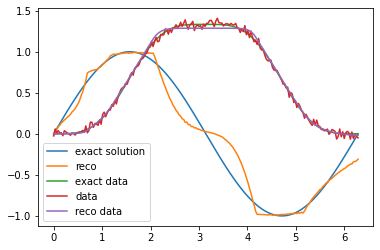

In [ ]:
stoprule = (
    # Method is slow, so need to use large number of iterations
    rules.CountIterations(max_iterations=100000) +
    rules.Discrepancy(
        setting.Hcodomain.norm, data,
        noiselevel=setting.Hcodomain.norm(noise),
        tau=1.3
    )
)

reco, reco_data = solver.run(stoprule)

plt.plot(grid.coords[0], exact_solution.T, label='exact solution')
plt.plot(grid.coords[0], reco, label='reco')
plt.plot(grid.coords[0], exact_data, label='exact data')
plt.plot(grid.coords[0], data, label='data')
plt.plot(grid.coords[0], reco_data, label='reco data')
plt.legend()
plt.show()

The reconstructions shows the piece-wise constant and piece-wise smooth feature expected for TV-regularization.

Regpy and imagingbase provide a wide range of possible solvers: IRGNM_CG, Landweber, FISTA, ADMM, Douglas-Rashford, Forward-Backward Splitting, Gradient Descent, Arrow-Hurwisz-Uzawa. Additionally, there is a wrapper for all gradient based optimizer routines in scipy.optimize (imagingbase.solvers.scipy_solver.Minimize). 